# NIH CXR Database Image Classifier using VGG16 and Random Forrest

In [1]:
"""
Feature Extractor: NN pretained on ImageNet
Output layer(s): SVM - traditional machine learning classifiers
Inspired by Sreenivas Bhattiprolu's classifier of similar approach
https://github.com/bnsreenu/python_for_microscopists/blob/master/158_classification_CNN_RF.py
"""
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# import glob
import cv2
import tensorflow as tf
import keras

# from keras.models import Model, Sequential
# from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from sklearn import preprocessing, metrics
# from sklearn.ensemble import RandomForestClassifier

In [2]:
#UTILITY FUCTION FOR TIME STAMPS
import calendar
import time
from datetime import datetime

def getTimeStamp():
  # Current GMT time in a tuple format
  current_GMT = time.gmtime()

  # ts stores timestamp
  ts = calendar.timegm(current_GMT)
  date_time = datetime.fromtimestamp(ts)
  # convert timestamp to string in dd-mm-yyyy HH:MM:SS
  return date_time.strftime("%m%d-%H%M%S")


In [3]:
# SHOW US WHAT YAH GOT
import sys
print(f"GPU: {tf.config.list_physical_devices('GPU')}  ")
print(f"CPU: {tf.config.list_physical_devices('CPU')}  ")
print(f"Python {sys.version}\nTensorflow{tf.__version__}")

GPU: []  
CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]  
Python 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:03:09) [Clang 13.0.1 ]
Tensorflow2.9.1


In [4]:
# define constansts
SIZE = 512  #Resize images, note original input shape for VGG is (224,244,3)
MAX_NUMBER_OF_EACH_FINDING = 525 #Total number of image for both testing and training
df = pd.read_csv('Data_Entry_2017_v2020.csv')
df = df[df['Patient Age']<100] #removing datapoints which having age greater than 100
print(f"Shape of full dataset: {df.shape}")
PA_df = df[df['View Position'] == 'PA'] #Fileter just for PA view images (exclude AP)
print(f"Shape of PA only dataset: {PA_df.shape}")
fullMatrchString = "No Finding|Fibrosis|Emphysema"
filtered_df = PA_df[PA_df['Finding Labels'].str.fullmatch(fullMatrchString)]; # Filter for a selection of parenchymal diseases.  Ie Cardiomegally, pleural thickening, pneumothorax excluded.  Note consolidation & pneumonia also excluded (consolidation, infiltration, PNA are not all exclusive descriptive terms; PNAs can be very different in appearance - round PNA vs lobal PNA vs viral PNA); Did not include edema because there are only 51 studies from 10 unique patients
# filtered_df = filtered_df.drop_duplicates(subset=['Patient ID'],ignore_index=True)  #UNIQUE PATIENTS ONLY
print(f"NUMBER OF PA STUDIES WITH FINDING\n{ filtered_df['Finding Labels'].value_counts()}") 
total_df=filtered_df.groupby('Finding Labels').head(MAX_NUMBER_OF_EACH_FINDING) ### cut down the count of each type to a max number, some gropus may have less than the max (PA edema is a small group)
# print(pd.crosstab(df['View Position'],df['Finding Labels']).head(10));
# test_df= filtered_df.groupby('Finding Labels').head(NUMBER_OF_EACH_FINDING_RESERVED_FOR_TESTING).reset_index(drop=True)
# train_df = total_df[~total_df['Image Index'].isin(test_df['Image Index'].to_list())]
# print(test_df)
# # SANITY CHECK PRINTS
# print(total_df.head()["Image Index"])
# print(test_df.head()["Image Index"])
# print(train_df.head()["Image Index"])

Shape of full dataset: (112120, 11)
Shape of PA only dataset: (67310, 11)
NUMBER OF PA STUDIES WITH FINDING
No Finding    39302
Fibrosis        648
Emphysema       525
Name: Finding Labels, dtype: int64


In [5]:
#define a function to the the images and their labels
def getImagesAndLabels(patients_df):
  labels = []
  images = []
  image_paths = patients_df['Image Index'].to_numpy()
  labels = patients_df['Finding Labels'].to_numpy()
  for img_path in image_paths:
    img_path = "dicom/NIH_images/"+img_path
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (SIZE, SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    images.append(img)

  return np.array(images), np.array(labels)
  #np.count_nonzero(Label_Array == 'No Finding')
  #Label_Array.size

In [6]:

images, labels = getImagesAndLabels(total_df)
# train_images, train_labels = getImagesAndLabels(train_df)
# test_images, test_labels = getImagesAndLabels(test_df)



In [7]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels,  test_labels = train_test_split(images, labels, random_state=0, test_size = 0.2, stratify=labels)
train_labels[:5]

array(['Fibrosis', 'No Finding', 'Fibrosis', 'Emphysema', 'No Finding'],
      dtype=object)

In [8]:
#Show the split between train and test sets.  By setting Straify = Labels it should keep the values proportional
unique_labels, train_labels_counts = np.unique(train_labels, return_counts=True)
#Show the split between train and test sets.  By setting Straify = Labels it should keep the values proportional
unique_labels, train_labels_counts ,np.unique(test_labels, return_counts=True), unique_labels.size


(array(['Emphysema', 'Fibrosis', 'No Finding'], dtype=object),
 array([160, 160, 160]),
 (array(['Emphysema', 'Fibrosis', 'No Finding'], dtype=object),
  array([40, 40, 40])),
 3)

In [112]:
# encode labels, ie from 'No Finding', 'Fibrosis', ... ====> 0, 1, ...
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(test_labels)
test_labels_encoded = label_encoder.transform(test_labels)
label_encoder.fit(train_labels)
train_labels_encoded = label_encoder.transform(train_labels)
label_encoder.classes_,train_labels[:5],train_labels_encoded[:5]

(array(['Emphysema', 'Fibrosis', 'No Finding'], dtype=object),
 array(['Fibrosis', 'No Finding', 'Fibrosis', 'Emphysema', 'No Finding'],
       dtype=object),
 array([1, 2, 1, 0, 2]))

In [10]:
#Rename to standard naming conventions
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

##### RESCALE AND FORMAT DATA

In [11]:

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train.shape

(480, 512, 512, 3)

In [12]:
# One hot encode y values for neural network. 
# Not currently used.  Will keep in case want to used in futures.
y_train_one_hot = keras.utils.to_categorical(y_train)
y_test_one_hot = keras.utils.to_categorical(y_test)
y_train_one_hot

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [13]:
# Sanity check
x_train[0,0,0] #should be greyscale pixel (R=G=B) in range O to 1 

array([0.97647059, 0.97647059, 0.97647059])

##### TRANSFER LEARNING  LOAD PRETRAINED KERAS APPLICATION

In [14]:
#Load model without output classifier/fully connected layers, set input shape to our custom SIZE 
#This will act as a "feature detector"
IMAGE_SHAPE = (SIZE, SIZE)
print(IMAGE_SHAPE)
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,  input_shape=(SIZE,SIZE,3), pooling='max')
base_model.trainable = False
inputs = keras.Input(shape=(SIZE, SIZE, 3))
# We make sure that the base_model is running in inference mode here
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
intermediate_outputs = base_model(inputs, training=False)
#base_model.summary()


(512, 512)


2022-08-17 15:31:30.456901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### CREATE OUTPUT LAYERS AND ADD TO THE BASE MODEL

In [15]:
### CREATE A SVM (SUPPORT VECTOR MACHINE) FOR CLASSIFYING
### SVM example: https://github.com/krishnaik06/Complete-Deep-Learning/blob/master/Image%20Classification%20Using%20SVM.ipynb
# # #FLATTEN - MAY NOT BE NEEDED WITH SOME BASE MODELS DEPENDING OUT OUTPUT SHAPE, COULD DO GLOBALMAXPOOLING INSTEAD
# # x = keras.layers.Flatten()(x)
# # # Make Fully Connection Layer
# x = keras.layers.Dense(units=16, activation='relu')(intermediate_outputs)
# # USE LINEAR CLASSIFICATION FOR A BINARY CLASSIFIER
# outputs = keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear')(x) 
# # # USE LINEAR CLASSIFICATION FOR A BINARY CLASSIFIER
# # outputs = keras.layers.Dense(XXXXCATEGORYNUMBER, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(x) 


### Create a simple final dense NN layer

outputs = tf.keras.layers.Dense( unique_labels.size, activation = tf.keras.activations.softmax)(intermediate_outputs)
print("Model outputs categories/labels: ", unique_labels.size)

### CREATE OUR FINAL MODEL
model = keras.Model(inputs, outputs)

# #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
# for layer in model.layers:
# 	layer.trainable = False
model.summary()  #Trainable parameters will be 0

Model outputs categories/labels:  3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [30]:
# Compiling the CNN
model.compile(
  optimizer = 'adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#  logits=TrUe /// loss = 'hinge', 
  metrics = ['accuracy']) #'sparse_categorical_crossentropy'
# generate path wehere you want to save your checkpoints
checkpoint_path = f"checkpoints/{getTimeStamp()}_weights.h5"
# define a callback that will save the model weights after every epoch 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  #save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  verbose=1,
  save_best_only=True)

In [31]:
#Train the CNN model
EPOCHS=10
BATCH_SIZE=16
history = model.fit(
  x_train, y_train, 
  epochs=EPOCHS, 
  batch_size=BATCH_SIZE, 
  validation_data = (x_test, y_test), 
  callbacks=[model_checkpoint_callback])

Epoch 1/10
30/30 [==============================] - ETA: 0s - loss: 1.5522 - accuracy: 0.4375 
Epoch 1: val_accuracy improved from -inf to 0.42500, saving model to checkpoints/0817-162237_weights.h5
30/30 [==============================] - 392s 13s/step - loss: 1.5522 - accuracy: 0.4375 - val_loss: 1.3799 - val_accuracy: 0.4250
Epoch 2/10
30/30 [==============================] - ETA: 0s - loss: 1.1325 - accuracy: 0.4812
Epoch 2: val_accuracy improved from 0.42500 to 0.47500, saving model to checkpoints/0817-162237_weights.h5
30/30 [==============================] - 303s 10s/step - loss: 1.1325 - accuracy: 0.4812 - val_loss: 1.2805 - val_accuracy: 0.4750
Epoch 3/10
30/30 [==============================] - ETA: 0s - loss: 0.9244 - accuracy: 0.5708
Epoch 3: val_accuracy did not improve from 0.47500
30/30 [==============================] - 253s 8s/step - loss: 0.9244 - accuracy: 0.5708 - val_loss: 1.3351 - val_accuracy: 0.4083
Epoch 4/10
30/30 [==============================] - ETA: 0s - l

In [92]:
## load model weights from file
if(False): ##I don't want this to run noramlly
  new_model = keras.models.load_model(checkpoint_path)
    # assert_allclose(model.predict(x_train), new_model.predict(x_train), 1e-5)
  # continue fitting the model
  # generate a new path wehere you want to save your checkpoints
  checkpoint_path = f"checkpoints/{getTimeStamp()}_weights.h5"
  # define a callback wutg the new path name
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)
  ##RESTART TRAINING
  history = new_model.fit( 
    x_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data = (x_test, y_test), 
    callbacks=[model_checkpoint_callback])
model= keras.models.load_model(checkpoint_path)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


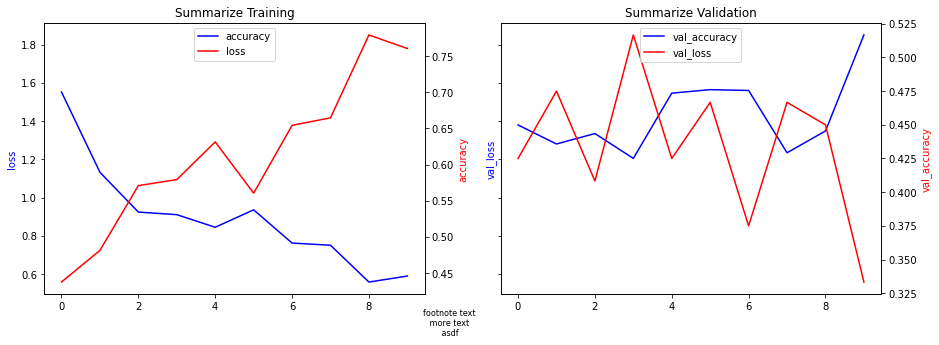

In [91]:
print(history.history.keys())
# summarize training
fig, (ax1,bx1), = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
l1, = ax1.plot(history.history['loss'], color='blue') 
ax2 = ax1.twinx()
l2, = ax2.plot(history.history['accuracy'], color='red')
ax1.set_ylabel('loss' , color='blue')
ax2.set_ylabel('accuracy', color='red' )
plt.legend([l1, l2], ["accuracy", "loss"], loc="upper center")
plt.xlabel('epochs')
plt.title('Summarize Training')
plt.figtext(0.5, 0.01, 'footnote text\n more text \n asdf', horizontalalignment='center', fontsize=8)
# plt.show()

# summarize validation
# fig, ax1 = plt.subplots()
l1, = bx1.plot(history.history['val_loss'], color='blue') 
bx2 = bx1.twinx()
l2, = bx2.plot(history.history['val_accuracy'], color='red')
bx1.set_ylabel('val_loss' , color='blue')
bx2.set_ylabel('val_accuracy', color='red' )
plt.legend([l1, l2], ["val_accuracy", "val_loss"], loc="upper center")
plt.xlabel('epochs')
plt.title('Summarize Validation')
plt.show()

# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

##### EXTRACT FEATURES USING THE PRETRAINED CNN

In [93]:
#Send test data through the model to get the output values
X_test_feature = model.predict(x_test)

# X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

4/4 [==============================] - 76s 17s/step


In [96]:
X_test_feature[:9],X_test_feature.shape
flattened = X_test_feature.argmax(axis=1)

Total accuracy =  0.5166666666666667


(array(['Emphysema', 'Fibrosis', 'No Finding'], dtype=object),
 array([[21,  7, 12],
        [ 3, 21, 16],
        [ 8, 12, 20]]))

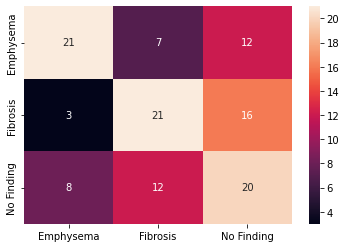

In [117]:
labels_from_predictions = label_encoder.inverse_transform(flattened)
accuracy = metrics.accuracy_score(y_test, flattened)
print ("Total accuracy = ", accuracy)
cm = metrics.confusion_matrix(test_labels,labels_from_predictions, labels = label_encoder.classes_)
cm_df =df = pd.DataFrame(data = cm, 
  index = label_encoder.classes_,
  columns = label_encoder.classes_)
heatmap =sns.heatmap(cm_df, annot=True)
label_encoder.classes_,cm

MAKE A RANDOM FOREST LAYER

In [ ]:

RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = label_encoder.inverse_transform(prediction_RF)

In [ ]:
#Print overall accuracy
accuracy = metrics.accuracy_score(test_labels, prediction_RF)
print ("Accuracy = ", accuracy)

In [ ]:
# from sklearn.metrics import confusion_matrix
#Confusion Matrix - verify accuracy of each class
cm = metrics.confusion_matrix(test_labels, prediction_RF)
#print(cm)
heatmap =sns.heatmap(cm, annot=True)

In [ ]:

#Save confusion matrix
heatmap.get_figure().savefig(f"confusion_matrices/{getTimeStamp()}_VGG16-RF_cats{cm.shape[0]}-{MAX_NUMBER_OF_EACH_FINDING}-{NUMBER_OF_EACH_FINDING_RESERVED_FOR_TESTING}_size{SIZE}_acc{round(accuracy,2)}.png")

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = label_encoder.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])